In [4]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

Используем один из "игрушечных" датасетов из той же библиотеки.

In [5]:
from sklearn.datasets import load_diabetes

In [6]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [8]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [9]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [10]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [11]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [12]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [13]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [14]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1181.823674938099
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4123.792064511442


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [15]:
import matplotlib.pyplot as plt

In [16]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

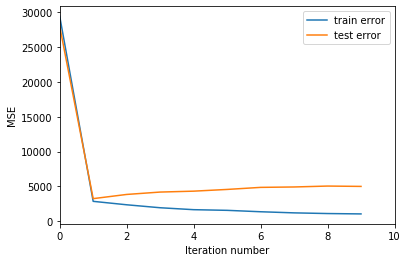

In [48]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [17]:
n_trees = 100
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [50]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1.2756646688413324
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 1 на тестовой выборке: 6191.019973715586


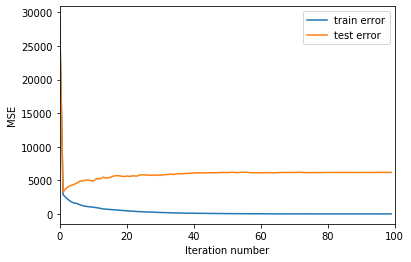

In [51]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [18]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [19]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 922.5278114297695
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3018.754147885837


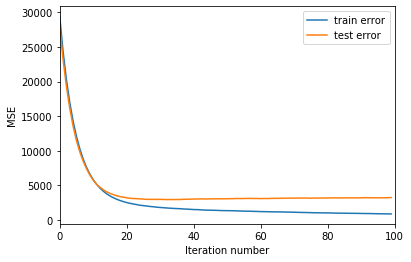

In [54]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [20]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [21]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 6196.475832326782
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 5882.86782112978


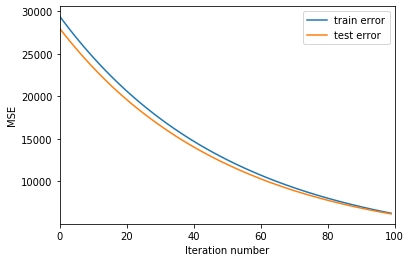

In [57]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

#**Немного модернизируем функцию evaluate_alg и создадим новую для вывода данных в цикле в зависимости от глубины и количества деревьев и проанализируем данные.**

Ошибка алгоритма из 1 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 28934.303604460565
Ошибка алгоритма из 1 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 27508.696316153113


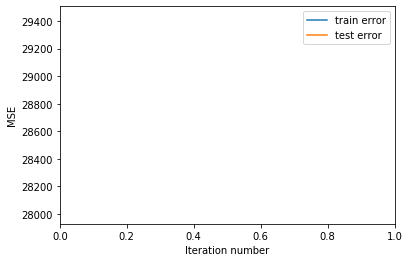

Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 28905.956164199808
Ошибка алгоритма из 1 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 27496.578659625113


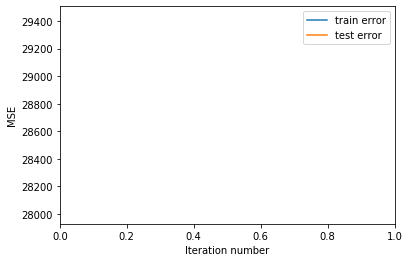

Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 28887.701455607817
Ошибка алгоритма из 1 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 27493.52488882942


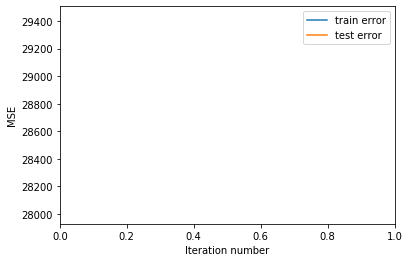

Ошибка алгоритма из 1 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 28854.67060068974
Ошибка алгоритма из 1 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 27486.032683915535


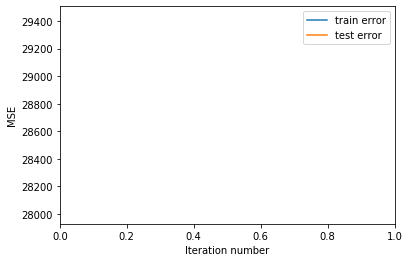

Ошибка алгоритма из 3 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 27963.096610330747
Ошибка алгоритма из 3 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 26555.44475717092


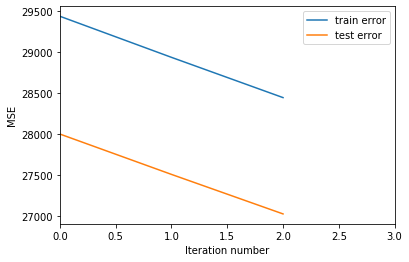

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 27879.739098496735
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 26518.516068569792


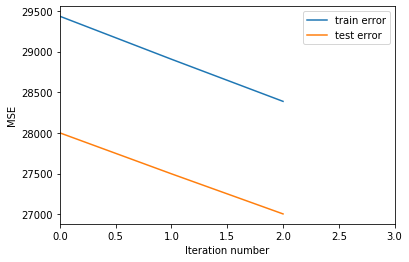

Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 27825.621238045293
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 26500.182335862664


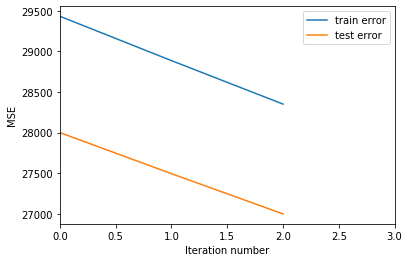

Ошибка алгоритма из 3 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 27728.83752514003
Ошибка алгоритма из 3 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 26484.85577133459


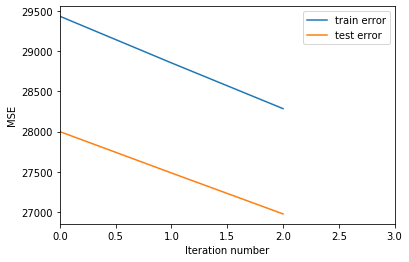

Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 24854.538747590363
Ошибка алгоритма из 10 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 23539.868261677177


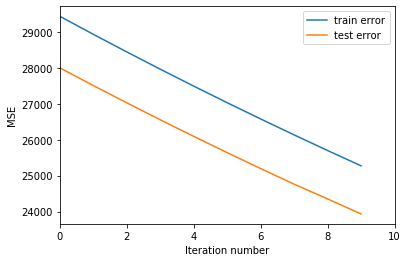

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 24596.644854030295
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 23389.092649212496


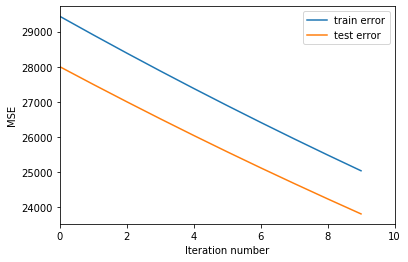

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 24425.82868128367
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 23299.637101174987


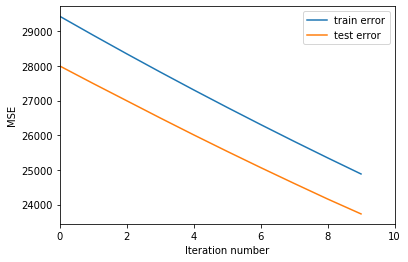

Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 24125.52624171639
Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 23350.272881296652


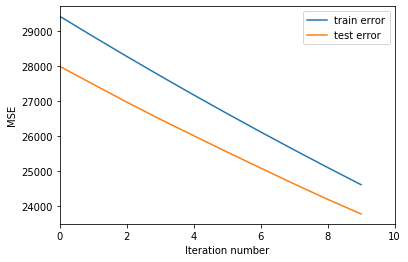

Ошибка алгоритма из 20 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 21095.21130800511
Ошибка алгоритма из 20 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 19927.200558763565


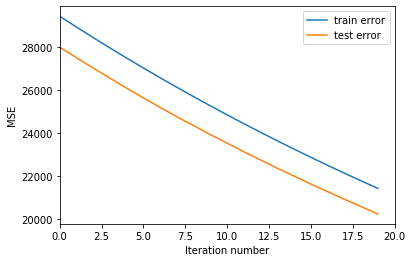

Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 20636.823956273092
Ошибка алгоритма из 20 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 19622.851383549467


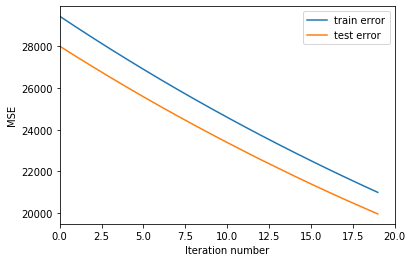

Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 20315.54250483578
Ошибка алгоритма из 20 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 19469.705100812473


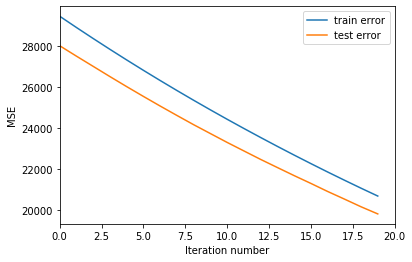

Ошибка алгоритма из 20 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 19772.968330174175
Ошибка алгоритма из 20 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 19662.49756346776


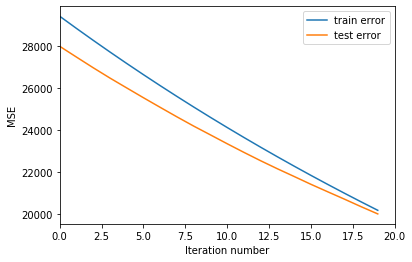

Ошибка алгоритма из 30 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 18004.70731744667
Ошибка алгоритма из 30 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 16942.687965194833


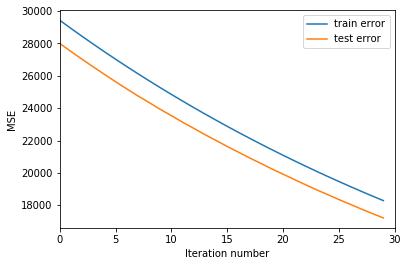

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 17391.284508983124
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 16570.80150674413


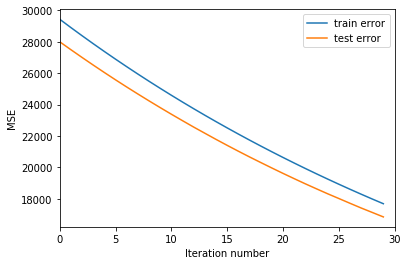

Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 16947.436677197533
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 16315.004847032227


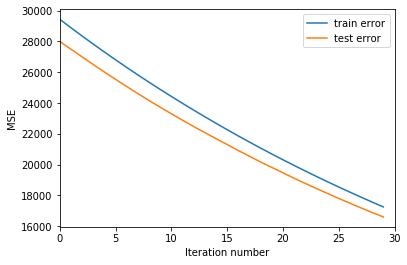

Ошибка алгоритма из 30 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 16206.917954464474
Ошибка алгоритма из 30 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 16647.690835375986


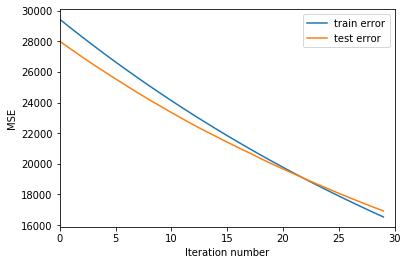

Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 13369.190321452556
Ошибка алгоритма из 50 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 12470.447346807625


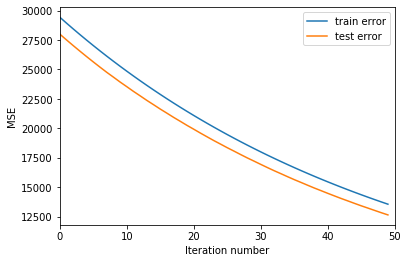

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 12538.51719490665
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 12001.463363026338


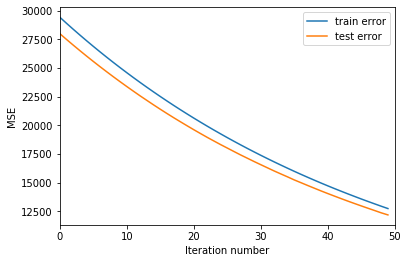

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 11888.044686024068
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 11764.635537564855


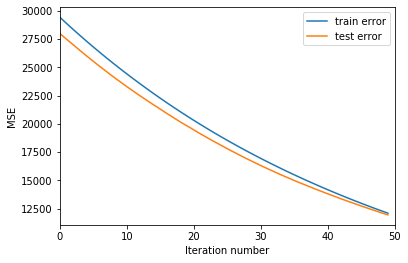

Ошибка алгоритма из 50 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 10899.883148722956
Ошибка алгоритма из 50 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 12270.944418264338


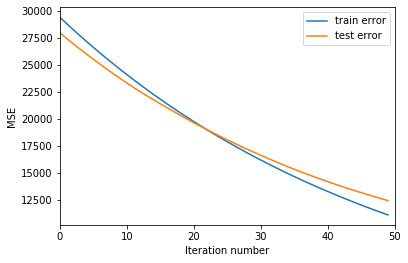

Ошибка алгоритма из 100 деревьев глубиной 1     с шагом 0.01 на тренировочной t: 7268.465733421733
Ошибка алгоритма из 100 деревьев глубиной 1     с шагом 0.01 на тестовой выборке: 6669.375252670433


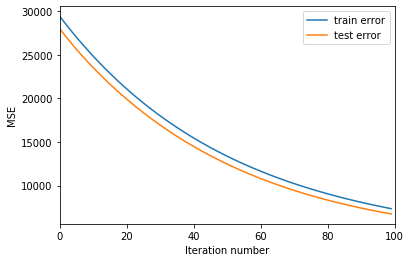

Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тренировочной t: 6168.674958595389
Ошибка алгоритма из 100 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 6099.217444295976


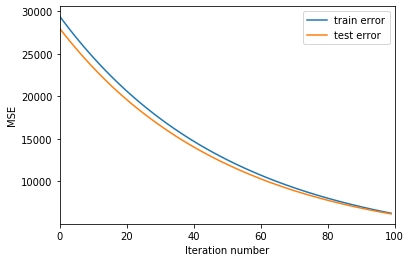

Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.01 на тренировочной t: 5236.954736052257
Ошибка алгоритма из 100 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 6018.271353550008


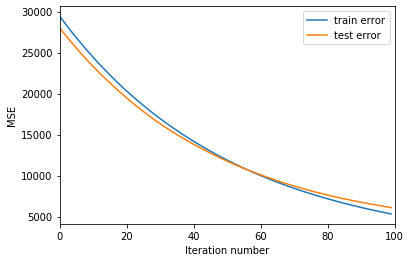

Ошибка алгоритма из 100 деревьев глубиной 10     с шагом 0.01 на тренировочной t: 4052.6532900506995
Ошибка алгоритма из 100 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 6832.185961611504


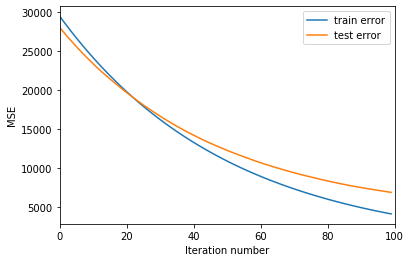

In [58]:
n_trees = [1,3,10, 20, 30,50,100]
max_depth = [1,3,5,10]
eta = 0.01


# Запишем все функцию (обучение, вывод, график) и будем выводить ошибки в зависимости от количества деревьев в ансамбле и от максимальной глубины деревьев и изменим функцию evaluate_alg

def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {t} деревьев глубиной {d} \
    с шагом {eta} на тренировочной t: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {t} деревьев глубиной {d} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')


def error_evaluate_plot(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
    get_error_plot(n_trees, train_errors, test_errors)


for t in n_trees:
    for d in max_depth:
        error_evaluate_plot(t, d, X_train, X_test, y_train, y_test, coefs, eta)
        



In [103]:
# 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг.
# Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке 
# в зависимости от числа итераций.


In [104]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5)

In [105]:
# Функция стохастического градиентного спуска линейно регрессии

def eval_sgd_model(X, y, iterations, qty_in_batch=1, alpha=1e-4):
    i_sgd = []
    err_sgd = []
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    n_batch = n // qty_in_batch
    if n % qty_in_batch != 0:
        n_batch += 1
    for i in range(1, iterations+1):
        for b in range(n_batch):
            start_ = qty_in_batch*b
            end_ = qty_in_batch*(b+1)

            # print(b, n_batch, start_, end_)

            X_tmp = X[:, start_ : end_]
            y_tmp = y[start_ : end_]
            y_pred_tmp = np.dot(W, X_tmp)
            err = mean_squared_error(y_tmp, y_pred_tmp)
            W -= (alpha * (1/n * 2 * np.dot((y_pred_tmp - y_tmp), X_tmp.T)))

        if i % (iterations / 800) == 0:
                i_sgd.append(i)
                err_sgd.append(err)
                # print(err)
    # plt.axis(ymax=50, xmax=400)
    plt.grid(True)      
    plt.suptitle('sgd_model')
    return i_sgd, err_sgd

#     return W

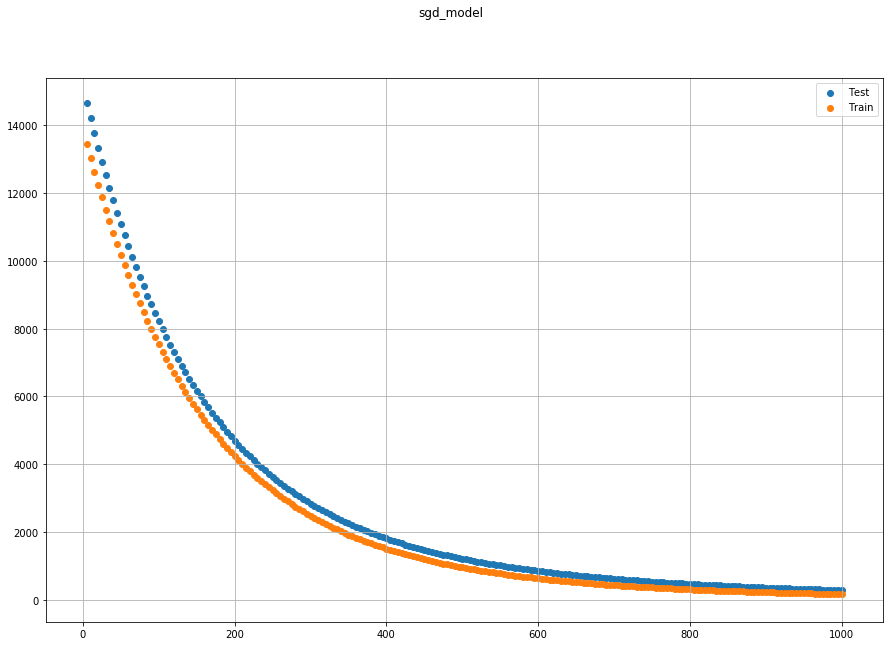

In [106]:
plt.figure(figsize=(15,10))

i_sgd, err_sgd = eval_sgd_model(X_test, y_test, iterations=1000, alpha=1e-2)
plt.scatter(i_sgd, err_sgd, label ='Test')

i_sgd, err_sgd = eval_sgd_model(X_train, y_train, iterations=1000, alpha=1e-2)
plt.scatter(i_sgd, err_sgd, label ='Train')

plt.legend()
plt.show()


In [107]:
# Не знаю получилось ли сделать это задание, но переделал функцию по подобию стохастического градиентного спуска
# Сделал 20 интераций, так как и это занимает много времени.
# и немного поэкспериментировал

In [108]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, qty_in_batch=1, alpha=1e-4, iterations=20):
    
    # Деревья будем записывать в список, а так же создадим список для вывода на графике итерации, и тестовые и тренировочные данные
    
    trees = []
    train_err_sgb = []
    test_err_sgb = []
    iterations_sgb = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    n = X.shape[1]
    n_batch = n // qty_in_batch
    if n % qty_in_batch != 0:
        n_batch += 1
    
    for i in range(n_trees, iterations):
        for b in range(n_batch):
            tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)

                train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
                test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            else:
                # Получим ответы на текущей композиции
                target = gb_predict(X_train, trees, coefs, eta)

                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, bias(y_train, target))

                train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
                test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            iterations_sgb.append(i)

            trees.append(tree)


    return trees, train_errors, test_errors, iterations_sgb

In [109]:
n_trees = 5
eta = 0.01
max_depth = 3


In [110]:
trees, train_errors, test_errors, iterations_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

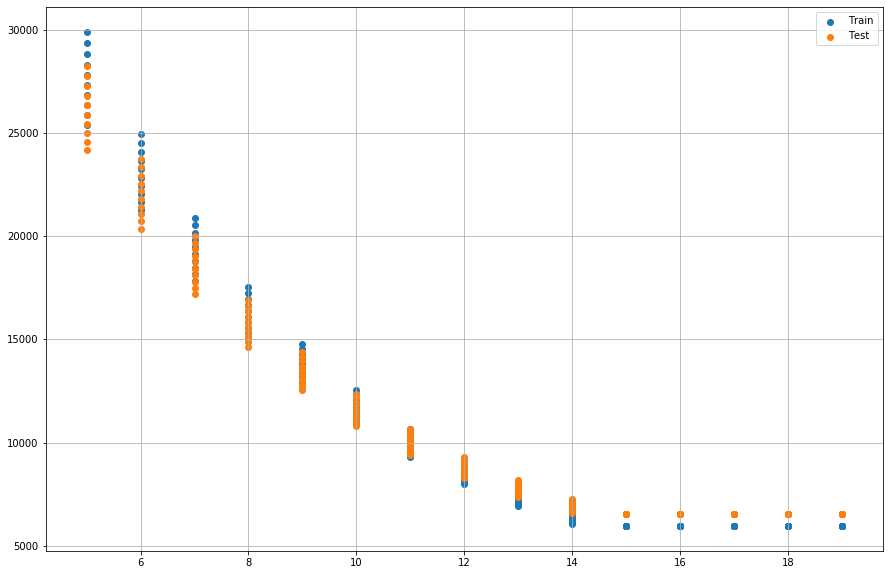

In [111]:
plt.figure(figsize=(15,10))
plt.scatter(iterations_sgb, train_errors, label ='Train')
plt.scatter(iterations_sgb, test_errors, label ='Test')

plt.grid(True)
plt.legend()
plt.show()

In [115]:
# На 15й итерации не идет улушчение показателей и разница между тестовой и тренировочной выборокой становится минимальной. 
# Посмотрим на разницу ошибок графике

In [116]:
differ = np.array(train_errors)-np.array(test_errors)

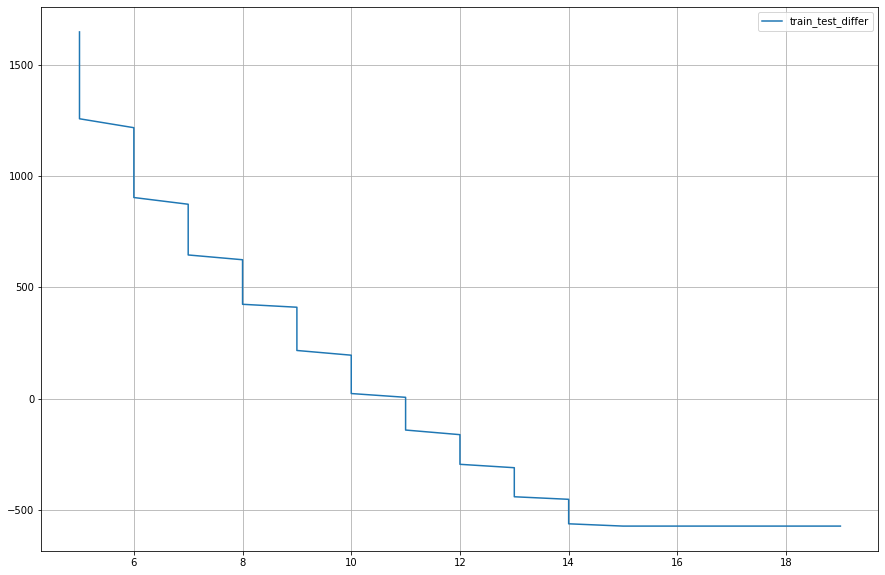

In [117]:
plt.figure(figsize=(15,10))
plt.plot(iterations_sgb, differ, label ='train_test_differ')

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# На 11 итерации разница ошибки между тестовой и тренировочной выборки стремится к нулю.